In [217]:
from process import * 
from utils import * 
from solver import *
import torch 
from torch import distributions as pyd
import matplotlib.pyplot as plt 
import seaborn as sns 

In [108]:
import importlib
modules = ["process", "maxent", "optimizer"]
def load_modules(modules): 
    for module in modules:
        imported_module = importlib.import_module(module)
        importlib.reload(imported_module)


load_modules(modules)

In [40]:
states = 25
n_actions = 6

In [39]:
trajectories = read_json("data/trajectories_100.json")

In [41]:
T = convert_traj(trajectories)

p_transition = calc_tran_model(T, states, n_actions)
terminal_states = calc_terminal_states(trajectories)

reward, _ = train_single_intent(T, p_transition, states, terminal_states)

reward = np.tile(reward.reshape(-1, 1), n_actions)

mu = calc_start_dist(list(trajectories.values()), states)

np.savez(f"mdp/mdp_{states}", states=states, n_actions=n_actions, p_transition=p_transition, reward=reward, terminal_states=terminal_states, mu=mu)


/Users/jaydenpersonnat/cs184-project/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [191]:
mdp_params = np.load("mdp/mdp_25.npz")

reward = mdp_params['reward']
mu = mdp_params['mu']
p_transition = mdp_params['p_transition']
states = mdp_params['states']
actions = mdp_params['n_actions']

In [192]:
reward

array([[38.39752001, 38.39752001, 38.39752001, 38.39752001, 38.39752001,
        38.39752001],
       [ 1.12485712,  1.12485712,  1.12485712,  1.12485712,  1.12485712,
         1.12485712],
       [ 1.17600523,  1.17600523,  1.17600523,  1.17600523,  1.17600523,
         1.17600523],
       [51.99249028, 51.99249028, 51.99249028, 51.99249028, 51.99249028,
        51.99249028],
       [ 1.83334091,  1.83334091,  1.83334091,  1.83334091,  1.83334091,
         1.83334091],
       [ 1.00021872,  1.00021872,  1.00021872,  1.00021872,  1.00021872,
         1.00021872],
       [ 1.16186023,  1.16186023,  1.16186023,  1.16186023,  1.16186023,
         1.16186023],
       [ 3.44573696,  3.44573696,  3.44573696,  3.44573696,  3.44573696,
         3.44573696],
       [13.14402329, 13.14402329, 13.14402329, 13.14402329, 13.14402329,
        13.14402329],
       [ 1.08879436,  1.08879436,  1.08879436,  1.08879436,  1.08879436,
         1.08879436],
       [ 1.59807803,  1.59807803,  1.59807803,  1.

In [193]:
int(actions)

6

In [194]:
import torch

In [195]:
import solver as S

In [196]:
reward.T[0]

array([38.39752001,  1.12485712,  1.17600523, 51.99249028,  1.83334091,
        1.00021872,  1.16186023,  3.44573696, 13.14402329,  1.08879436,
        1.59807803, 66.14211815,  1.1649133 , 12.51474263,  1.00109406,
        2.29735087, 10.31409265,  1.27511855, 11.4364596 ,  1.09780021,
        1.1598293 ,  7.38856657,  1.10036405, 53.93822779, 26.40797182])

In [213]:
def value_iteration(p, reward, discount, mu, H=1000, eps=1e-3, max_iterations=2000):
    """
    Basic value-iteration algorithm to solve the given MDP.

    Args:
        p: The transition probabilities of the MDP as table
            `[from: Integer, to: Integer, action: Integer] -> probability: Float`
            specifying the probability of a transition from state `from` to
            state `to` via action `action` to succeed.
        reward: The reward signal per state as table
            `[state: Integer] -> reward: Float`.
        discount: The discount (gamma) applied during value-iteration.
        eps: The threshold to be used as convergence criterion. Convergence
            is assumed if the value-function changes less than the threshold
            on all states in a single iteration.

    Returns:
        The value function as table `[state: Integer] -> value: Float`.
    """
    n_states, _, n_actions = p.shape
    v = np.zeros(n_states)

    # Setup transition probability matrices for easy use with numpy.
    #
    # This is an array of matrices, one matrix per action. Multiplying
    # state-values v(s) with one of these matrices P_a for action a represents
    # the equation
    #     P_a * [ v(s_i) ]_i^T = [ sum_k p(s_k | s_j, a) * v(s_K) ]_j^T
    p_transition = p 

    p = [np.matrix(p[:, :, a]) for a in range(n_actions)]

    delta = np.inf

    epoch = 0 

    total_rewards = [] 

    while delta > eps and epoch < max_iterations:      # iterate until convergence
        v_old = v

        # compute state-action values (note: we actually have Q[a, s] here)
        q = discount * np.array([p[a] @ v for a in range(n_actions)])

        # compute state values
        v = reward + np.max(q, axis=0)[0]


        state = np.random.choice(a=len(mu), p=mu)

        total_reward = 0

        # rollout trajectory
        for _ in range(H): 

            policy = np.argmax(q, axis = 0).reshape(-1, )

            action = policy[state]

            transition_probabilities = p_transition[state, :, action]
            # move on to next state 
            state = np.random.choice(a=len(transition_probabilities), p=transition_probabilities)

            # add reward for that state
            total_reward += reward[state]


        # compute maximum delta
        delta = np.max(np.abs(v_old - v))

        epoch += 1 

        total_rewards.append(total_reward)
        print(f"Episode: {epoch}, Total Reward: {total_reward}")

    return v, q, total_rewards, 


In [214]:
V, Q, total_rewards = value_iteration(p_transition, reward.T[0], 1, mu)

Episode: 1, Total Reward: 50532.45617074314
Episode: 2, Total Reward: 62150.81731144656
Episode: 3, Total Reward: 60710.8184933182
Episode: 4, Total Reward: 61407.56482272741
Episode: 5, Total Reward: 61524.7324783601
Episode: 6, Total Reward: 61704.7030933984
Episode: 7, Total Reward: 61480.61261703153
Episode: 8, Total Reward: 61130.11435470325
Episode: 9, Total Reward: 62359.682406725005
Episode: 10, Total Reward: 60318.66211415104
Episode: 11, Total Reward: 63341.21082741614
Episode: 12, Total Reward: 61558.97109765261
Episode: 13, Total Reward: 62967.353839828145
Episode: 14, Total Reward: 61102.33549273539
Episode: 15, Total Reward: 62331.91247865101
Episode: 16, Total Reward: 63617.67425094127
Episode: 17, Total Reward: 62757.36105895524
Episode: 18, Total Reward: 62486.432867851
Episode: 19, Total Reward: 62628.081489898075
Episode: 20, Total Reward: 61230.91621065976
Episode: 21, Total Reward: 61995.92269487661
Episode: 22, Total Reward: 62853.76588009265
Episode: 23, Total Re

In [218]:
def plot_reward_heatmap(reward_function):
    """
    Plots a 5x5 heatmap using seaborn given a 1D numpy array of length 25.

    Parameters:
    reward_function (numpy array): A 1D numpy array of length 25 representing the reward function.
    """
    # if reward_function.shape != (25,):
    #     raise ValueError("Reward function must be a 1D numpy array of length 25.")

    sqrt_states = int(np.sqrt(reward_function.shape))

    # Reshape the 1D array to 5x5
    reward_matrix = reward_function.reshape(sqrt_states, sqrt_states)

    # Plot using seaborn
    plt.figure(figsize=(8, 6))
    heatmap = sns.heatmap(reward_matrix, annot=True, cmap="viridis", cbar=True)
    heatmap.set_xticklabels(range(sqrt_states))
    heatmap.set_yticklabels(range(sqrt_states))
    # plt.xlabel("X-axis")
    # plt.ylabel("Y-axis")
    plt.title("Single Intent Reward Function")
    plt.show()


/var/folders/rl/fmlvy3bj3b15n9nltj9m084c0000gn/T/ipykernel_6515/3307198995.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sqrt_states = int(np.sqrt(reward_function.shape))


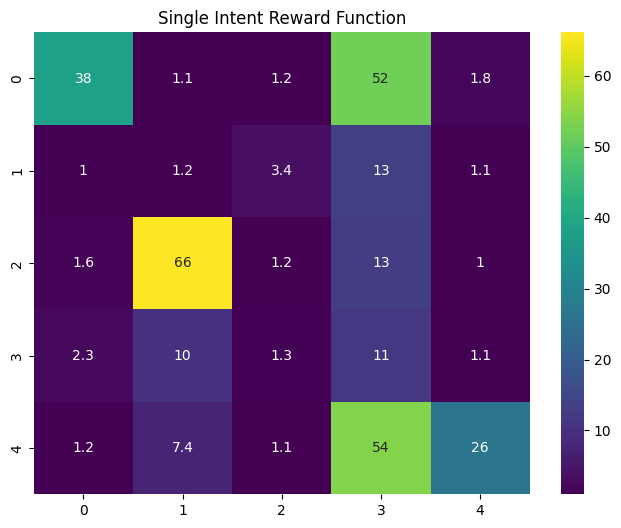

In [220]:
plot_reward_heatmap(reward.T[0])